In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import re, string
import seaborn as sns
import pickle


from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')

from src.data.get_dataset import load_dataset
from src.data.plot_functions import *
from src.data.feature_engineering import preprocess_train_df, pr, tokenize, TF_IDF_Vectorizer
from src.conf.global_variables import TOXIC_COMMENT_DATA_PATH, SEED, LABELS, COMMENT
from src.models.train_model import *
from src.models.predict_model import get_prediction
from src.models.CV_score_model import cross_val_score_classifier, compute_CV_score_for_each_class
from src.models.save_and_load_models import save_models, load_models

## Load dataset 

In [2]:
train_df, test_df, test_labels_df = load_dataset(TOXIC_COMMENT_DATA_PATH)

In [3]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


## Length of all comments histogram

Mean length :394.0732213246768, Std :590.7202819048919, Max:5000


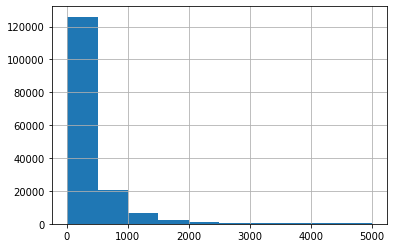

In [5]:
plot_length_comments_hist(train_df)

## Multiple labels per comment

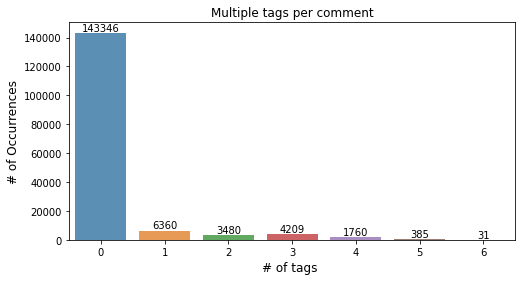

In [6]:
plot_nb_of_labels_per_comments(train_df)

## Feature Engineering

In [7]:
train_df, test_df = preprocess_train_df(train_df, test_df, LABELS, COMMENT)

In [8]:
trn_term_doc, test_term_doc, vec = TF_IDF_Vectorizer(train_df,test_df, COMMENT, tokenize)

In [9]:
x = trn_term_doc
test_x = test_term_doc
x, test_x

(<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 17775119 stored elements in Compressed Sparse Row format>,
 <153164x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 14765768 stored elements in Compressed Sparse Row format>)

## Cross Val Score

In [10]:
scores = compute_CV_score_for_each_class(train_df,LABELS,x)

CV score for class toxic is 0.9796539447771728
CV score for class severe_toxic is 0.9873204530678681
CV score for class obscene is 0.9904597173219244
CV score for class threat is 0.9874389761277244


/Users/lea.naccache/opt/anaconda3/envs/nlp_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CV score for class insult is 0.9835955079090338
CV score for class identity_hate is 0.9763280783300535


In [11]:
print(np.mean(scores))

0.9841327795889628


## Train model 

In [12]:
x = trn_term_doc
y = train_df[LABELS]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=SEED)

In [13]:
all_classifiers_and_NB_coeff = fit_models(y_train,x_train, LABELS)

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult


/Users/lea.naccache/opt/anaconda3/envs/nlp_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


fit identity_hate


## Save the Model 

In [15]:
filename_list = save_models(all_classifiers_and_NB_coeff)

In [16]:
filename_list

['models_saved/trained_model_0.sav',
 'models_saved/trained_model_1.sav',
 'models_saved/trained_model_2.sav',
 'models_saved/trained_model_3.sav',
 'models_saved/trained_model_4.sav',
 'models_saved/trained_model_5.sav']

## Load the Model 

In [18]:
loaded_models_and_nb_coef = load_models(filename_list)

## Prediction

#### Prediction x_val (test labellisé)

In [19]:
y_preds,_ = get_prediction(x_val, loaded_models_and_nb_coef, LABELS)

In [20]:
roc_auc_score(y_val.values, y_preds)

0.9827173376415935

#### Prediction pour le test_df (non labellisé)

In [21]:
y_preds_unlabelized,_ = get_prediction(test_x, all_classifiers_and_NB_coeff, LABELS)

## Interpretability

In [23]:
feature_importance_LR = get_feature_importance_logistic_regression(LABELS, all_classifiers_and_NB_coeff)

In [30]:
feature_importance_LR_and_NB = get_feature_importance_LR_fois_nb_coef(LABELS, all_classifiers_and_NB_coeff)